# Introduction to TensorFlow Estimator

We will see how to create and train a model with several lines of code. We will also illustrate that boosted trees regression can capture (highly) nonlinear relationship, whereas linear regression cannot.

As usual, we start by important some libraries.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

## limit the amount of displayed messages by TF
tf.logging.set_verbosity(tf.logging.ERROR)

/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

## Create and display data

We generate some synthetic data, linear or nonlinear as you like, and create functions to display the data points as well as an approximative contour plot.

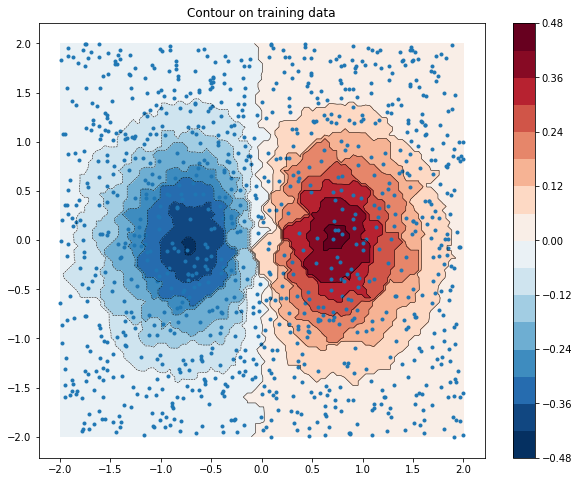

In [2]:
## generate some data
def func(x, y, type="nonlinear"):
    if type=="nonlinear":
        return x*np.exp(-x**2 - y**2)
    elif type=="linear":
        return x + 2*y
    else:
        raise ValueError('Unknown type.')
  
np.random.seed(0)
n_pts = 1000
x = np.random.uniform(low=-2, high=2, size=(n_pts, 1))
y = np.random.uniform(low=-2, high=2, size=(n_pts, 1))
z = func(x, y)
#z = func(x, y, "linear")

## map to a grid
grid_x, grid_y = np.mgrid[-2:2:100j, -2:2:100j]
grid_z = griddata(np.hstack([x,y]), z, (grid_x, grid_y), method='nearest')
grid_z = grid_z.squeeze()
grid_zmax = np.max(grid_z)
grid_zmin = -grid_zmax

## plot function
def plot_contour(x, y, z, zmax=grid_zmax, zmin=grid_zmin):
    plt.figure(figsize=(10, 8))
    plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    plt.contourf(x, y, z, 15, vmax=zmax, vmin=zmin, cmap='RdBu_r')
    plt.colorbar()
    pass

## display our sample
plot_contour(grid_x, grid_y, grid_z)
plt.scatter(x, y, marker='.')
plt.title('Contour on training data');

Those are just two functions making it easier to produce and collect predictions from an estimator.

In [3]:

def mypredict(est, df, shape=None):
    '''
    function to return prediction given an estimator
        est: estimator
        df: dictionnary of features
    '''
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    if shape is not None:
        preds = preds.reshape(shape)
    return preds

## gene
def predict_grid(est, grid_x, grid_y):
    '''make prediction on a specific grid of points'''
    df_eval = pd.DataFrame({'x' : grid_x.flatten(), 
                            'y' : grid_y.flatten()})
    preds = mypredict(est, df_eval, grid_x.shape)
    return(preds)

## Data handling: input_fn()

Estimators use a function to feed the trainer with data. Here, we create a function that creates this input function. Why? Because then we can use it for train data as well as test data.

We also create the corresponding feature columns to be passed as *abstract* model input.

In [4]:
## function to input data in the estimator
def make_input_fn(X, y, n_epochs=None):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs).batch(n_pts)
        return dataset
    return input_fn

## prepare data for estimator
df_train = pd.DataFrame({'x' : x.flatten(), 
                         'y' : y.flatten(), 
                         'z' : z.flatten()})
train_input_fn = make_input_fn(df_train, df_train.z)

## feature columns used as model input
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

## Create and train a linear regressor model

One line for each task!

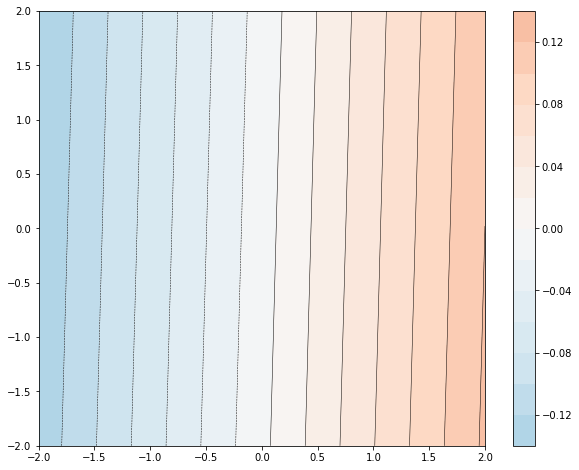

In [5]:
## create estimator
est = tf.estimator.LinearRegressor(fc)

## train model
est.train(train_input_fn, max_steps=500)

## similarly you can get the predictions (not in a nice format)
#gen = est.predict(train_input_fn)
## how it looks like
#import itertools
#for p in itertools.islice(gen, 5):
#    print(p)

## make predictions and plot
plot_contour(grid_x, grid_y, predict_grid(est, grid_x, grid_y))

## Create and train a boosted trees regressor model

One line as well, run it for different number of trees.

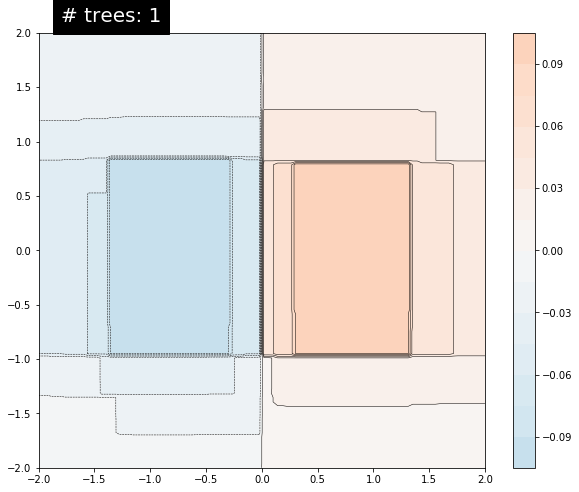

In [6]:
for n in [1]:
    ## create estimator
    est = tf.estimator.BoostedTreesRegressor(fc,
                                             n_batches_per_layer=1,
                                             n_trees=n)
    ## train model
    est.train(train_input_fn, max_steps=500)
    plot_contour(grid_x, grid_y, predict_grid(est, grid_x, grid_y))
    plt.text(-1.8, 2.1, '# trees: {}'.format(n), color='w', 
             backgroundcolor='black', size=20);

In [ ]:
for n in [10]:
    ## create estimator
    est = tf.estimator.BoostedTreesRegressor(fc,
                                             n_batches_per_layer=1,
                                             n_trees=n)
    ## train model
    est.train(train_input_fn, max_steps=500)
    plot_contour(grid_x, grid_y, predict_grid(est, grid_x, grid_y))
    plt.text(-1.8, 2.1, '# trees: {}'.format(n), color='w', 
             backgroundcolor='black', size=20);